In [1]:
import pandas as pd
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline
plt.style.use('fivethirtyeight')

## Monthly tonnage

In [92]:
df = pd.read_csv('monthly_tonnage.csv', na_values='NaN')

## make datetime, separate the year
df.MONTH = pd.to_datetime(df.MONTH)
df['year'] = df.MONTH.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
df.BOROUGH_ID = df.BOROUGH_ID.astype(str)

df = df[df.year > 2008] ## just for the past 10 years

## some math to get the percents and totals
df['total_recycled'] = df.PAPERTONSCOLLECTED + df.MGPTONSCOLLECTED
df['percent_recycled'] = df['total_recycled'] / df.REFUSETONSCOLLECTED

In [93]:
df.head(3)

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,year,total_recycled,percent_recycled
3,2012-03-01,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1,2012,552.4,0.462492
9,2012-01-01,Brooklyn,7,3156.7,436.6,343.4,NaN,NaN,NaN,20.1,3,2012,780.0,0.247093
13,2016-11-01,Brooklyn,7,3356.9,424.4,380.3,120.1,NaN,2.5,NaN,3,2016,804.7,0.239715


In [94]:
def get_boro_code(x):
    print(x.BOROUGH_ID.astype(str) + "{:02d}".format(x.COMMUNITYDISTRICT))
    
df.apply(get_boro_code, axis=1)

AttributeError: ("'str' object has no attribute 'astype'", 'occurred at index 3')

In [82]:
for district in df.COMMUNITYDISTRICT:
    print("{:02d}".format(district))

01
07
07
07
07
07
07
07
07
07
07
07
07
07
07
07
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
13
13
13
13
13
13
13
13
13
13
13
13
13
13
09
09
09
09
09
09
09
09
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
09
09
09
09
09
09
09
09
09
09
09
09
05
05
05
05
05
05
05
05
05
05
05
06
06
06
06
06
06
06
06
06
06
06
06
06
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
03
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
07
07
07
07
07
07
07
07
07
07
07
07
07
07
07
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
1

07
07
07
07
07
07
07
07
07
03
03
03
03
03
03
03
03
03
03
03
11
11
11
11
11
11
11
11
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
05
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
10
10
10
10
10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
01
15
15
15
15
15
15
15
15
15
15
15
15
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
09
05
05
05
05
05
05
05
05
05
05
05
05
06
06
06
06
06
06
06
06
06
06
06
06
06
06
06
06
03
03
03
03
03
03
03
03
03
03
03
03
03
03
12
12
12
12
12
12
12
12
12
12
12
12
02
02
02
02
02
02
02
02
02
02
02
02
02
02
07
07
07
07
07
07
07
07
07
07
07
07
07
07
07
07
07
14
14
14
14
14
14
14
14
14
14
14
14
14
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
02
04
04
04
0

In [74]:
"{:02d}".format(9)

'09'

In [51]:
f"{df.COMMUNITYDISTRICT.astype(str):2d}"

TypeError: unsupported format string passed to Series.__format__

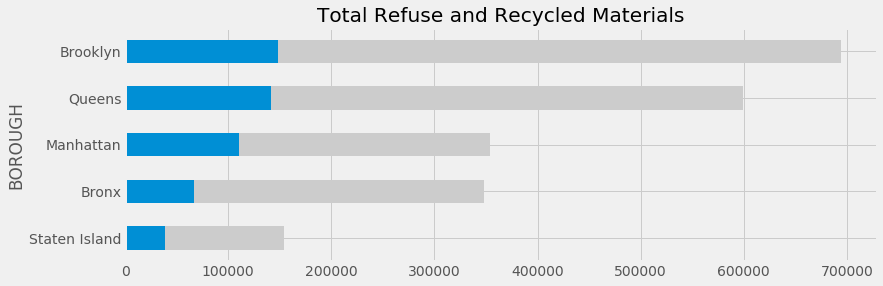

In [168]:
ax = df[df.year == 2019].groupby('BOROUGH').REFUSETONSCOLLECTED.sum().sort_values().plot(kind='barh', title='Total Recycled Materials', figsize=(12,4), color='#cccccc')
df[df.year == 2019].groupby('BOROUGH').total_recycled.sum().sort_values().plot(kind='barh', title='Total Refuse and Recycled Materials', figsize=(12,4), ax=ax)

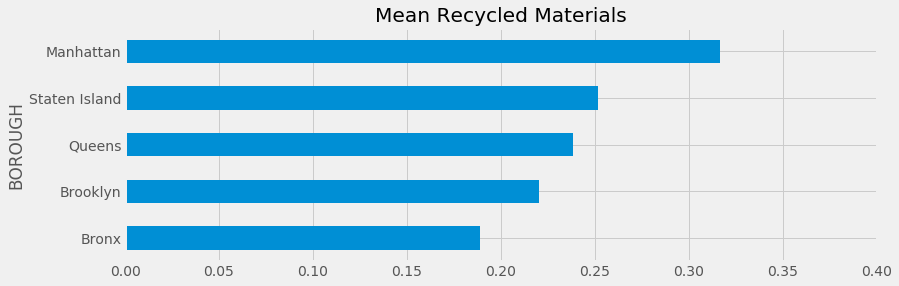

In [169]:
df[df.year == 2019].groupby('BOROUGH').percent_recycled.mean().sort_values().plot(kind='barh', title='Mean Recycled Materials', figsize=(12,4), xlim=(0,.4))

In [170]:
print('The community districts that has the highest mean percent recycled')
print(df.groupby(['BOROUGH', 'COMMUNITYDISTRICT']).percent_recycled.mean().reset_index().sort_values('percent_recycled', ascending=False).head())
print('\n')
print('The community districts that has the lowest mean percent recycled')
print(df.groupby(['BOROUGH', 'COMMUNITYDISTRICT']).percent_recycled.mean().reset_index().sort_values('percent_recycled', ascending=True).head())

The community districts that has the highest mean percent recycled
      BOROUGH  COMMUNITYDISTRICT  percent_recycled
30  Manhattan                  1          0.456923
17   Brooklyn                  6          0.440357
31  Manhattan                  2          0.365111
33  Manhattan                  4          0.359387
36  Manhattan                  7          0.358198


The community districts that has the lowest mean percent recycled
     BOROUGH  COMMUNITYDISTRICT  percent_recycled
3      Bronx                  4          0.105543
0      Bronx                  1          0.105900
27  Brooklyn                 16          0.112781
8      Bronx                  9          0.116825
2      Bronx                  3          0.118954


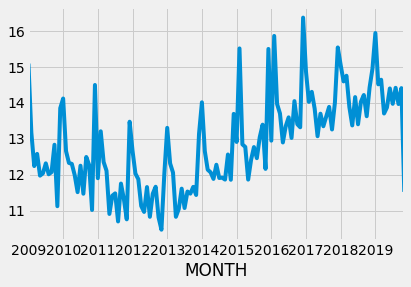

In [123]:
df.groupby('MONTH').percent_recycled.sum().plot()

BOROUGH
Bronx            AxesSubplot(0.08,0.07;0.87x0.81)
Brooklyn         AxesSubplot(0.08,0.07;0.87x0.81)
Manhattan        AxesSubplot(0.08,0.07;0.87x0.81)
Queens           AxesSubplot(0.08,0.07;0.87x0.81)
Staten Island    AxesSubplot(0.08,0.07;0.87x0.81)
dtype: object

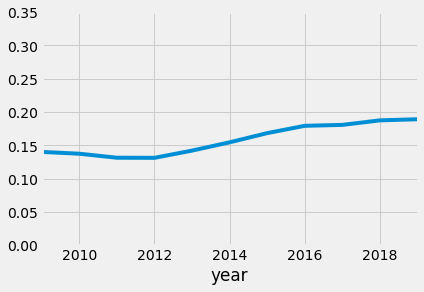

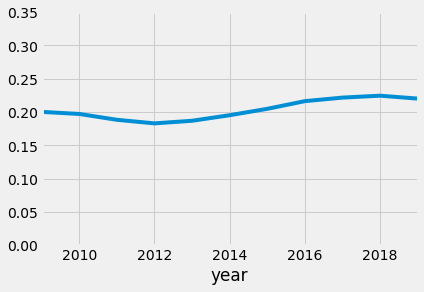

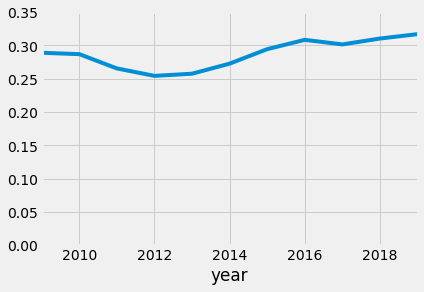

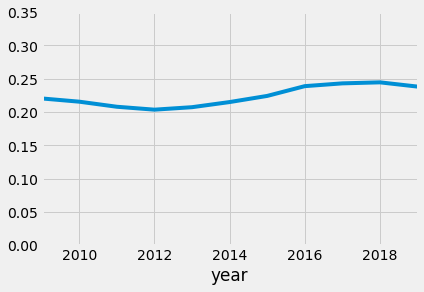

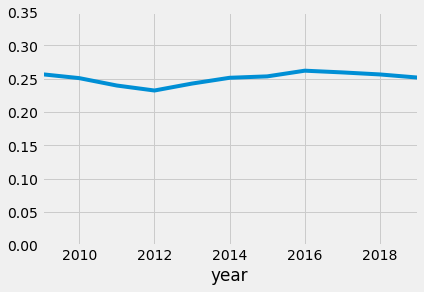

In [121]:
df_years_mean = df.groupby(['BOROUGH', 'year']).percent_recycled.mean().reset_index()
df_years_mean.groupby('BOROUGH').plot(x='year', y='percent_recycled', ylim=(0,.35), legend=False)

## 311 data regarding missed recyling collections

Data is <code>311_Service_Requests_from_2010_to_Present.csv</code>

I grabbed and filtered the data on NYC Open Data and filtered it to only include DSNY complaints mentioning recycling

In [180]:
df_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', usecols=['Unique Key', 'Created Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor','Location Type', 'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Resolution Description', 'Community Board', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude', 'Borough'])
df_311['year'] = df_311['Created Date'].str.extract('\d+\/\d+\/(\d+)') ## this grabs the year

In [181]:
df_311.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,City,Resolution Description,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Latitude,Longitude,year
0,44916024,11/13/2019 10:19:00 AM,DSNY,BCC - Queens West,Missed Collection (All Materials),1R Missed Recycling-All Materials,Sidewalk,11378.0,59-15 69 LANE,69 LANE,Maspeth,The Department of Sanitation is in the process...,05 QUEENS,QUEENS,1014336.0,203004.0,40.723825,-73.891457,2019


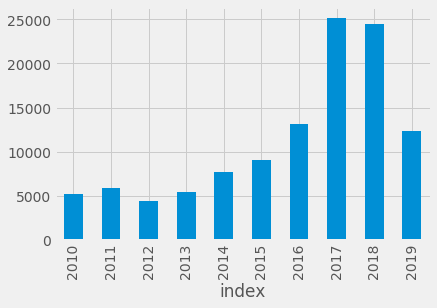

In [182]:
df_311.year.value_counts().reset_index().sort_values('index', ascending=True).plot(kind='bar', x='index', y='year', legend=False)

In [183]:
df_311['Community Board'].value_counts().head(10)

01 STATEN ISLAND    14443
03 STATEN ISLAND    13643
02 STATEN ISLAND     9859
01 BROOKLYN          5280
07 QUEENS            4791
12 BROOKLYN          3307
13 QUEENS            3241
03 BROOKLYN          2706
08 QUEENS            2661
12 QUEENS            2604
Name: Community Board, dtype: int64

In [186]:
df_311['Borough'].value_counts().head(6)

STATEN ISLAND    37952
BROOKLYN         32470
QUEENS           27294
MANHATTAN         8435
BRONX             6690
Unspecified          8
Name: Borough, dtype: int64